# 预训练图像分类模型预测摄像头实时画面

调用MMClassification模型库中的预训练图像分类模型，调用本地摄像头，进行逐帧实时图像分类预测，显示带标注结果的实时画面。

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

同济子豪兄：https://space.bilibili.com/1900783

测试运行环境：Macbook Pro

2022-8-16

## 在本地安装 MMCV 和 MMClassification 环境（见附录教程）

## 进入 mmclassification 目录

In [1]:
import os
os.chdir('mmclassification')

## 导入工具包

In [2]:
import os

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image # pillow
from tqdm import tqdm # 进度条

import mmcv
from mmcls.apis import init_model
from mmcls.datasets.pipelines import Compose

import matplotlib.pyplot as plt
%matplotlib inline

import torch

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cpu


## 载入预训练图像分类模型

In [5]:
# resnet18
config_file = 'configs/resnet/resnet18_8xb32_in1k.py'
checkpoint_file = 'checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth'

In [6]:
# # mobilenet v2
# config_file = 'configs/mobilenet_v2/mobilenet_v2_b32x8_imagenet.py'
# checkpoint_file = 'checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'

In [7]:
# 通过 config 配置文件 和 checkpoint 权重文件 构建模型
model = init_model(config_file, checkpoint_file, device=device)

load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth


/Users/tommy/Desktop/pytorch/mmclassification/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [8]:
cfg = model.cfg
# 去掉预处理的第一步，LoadImageFromFile
# 直接输入 img_array 而非 文件路径
cfg.data.test.pipeline.pop(0)
test_pipeline = Compose(cfg.data.test.pipeline)

## 载入ImageNet 1000图像分类标签

ImageNet 1000类别中文释义：https://github.com/ningbonb/imagenet_classes_chinese

In [10]:
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']

In [13]:
# idx_to_labels

## 获取摄像头的一帧画面

In [44]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!


In [31]:
img_bgr.shape

(720, 1280, 3)

In [32]:
# 预处理
data = test_pipeline({'img': img_bgr})
img = data['img'].unsqueeze(0).to(device)

# 前向预测
pred_softmax = model(img=img, return_loss=False, post_process=False)

In [33]:
pred_softmax.shape

torch.Size([1, 1000])

In [34]:
# 解析 top-n 预测结果
n = 5
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

In [35]:
pred_ids

array([823, 837, 617, 785, 457])

In [36]:
confs

array([0.13991451, 0.12885621, 0.05377053, 0.03645926, 0.03137221],
      dtype=float32)

In [37]:
# 在图像上写英文
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence)

    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, text, (50, 160 + 80 * i), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)

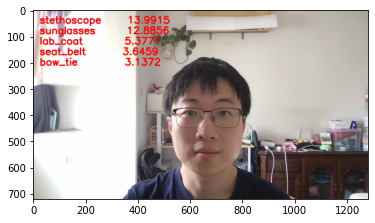

In [38]:
# 可视化展示
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
plt.imshow(img_rgb)
plt.show()

## 处理单帧画面的函数（英文）

In [52]:
# 处理帧函数
def process_frame(img):
    
    '''
    输入摄像头拍摄画面bgr-array，输出图像分类预测结果bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    # 预处理
    img_bgr = img
    data = test_pipeline({'img': img_bgr})
    img = data['img'].unsqueeze(0).to(device)
    
    # 前向预测
    pred_softmax = model(img=img, return_loss=False, post_process=False)
    
    # 解析 top-n 预测结果
    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

    # 在图像上写英文
    for i in range(n):
        class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
        confidence = confs[i] * 100 # 获取置信度
        text = '{:<15} {:>.4f}'.format(class_name, confidence)

        # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
        img_bgr = cv2.putText(img_bgr, text, (50, 160 + 80 * i), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img = cv2.putText(img_bgr, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img

## 调用摄像头获取每帧（模板）

In [53]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!
2022-08-16 12:55:08.880 python[98625:6482655] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (163.15 secs).
